In [1]:
import time
import argparse
import os
from IPython import display

import numpy as np
from scipy import io
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import tensorflow as tf
from tfdiffeq import odeint
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
keras.backend.set_floatx('float64')

# Load Data #

In [3]:
def load_matlab(filepath):
    matlab_data = io.loadmat(filepath)
    output_matlab = matlab_data['xs'] # 1-by-N array
    xs_matlab = output_matlab[0] # 1D np array of length N, each has dimension (ts, dimx)
    xdata = np.empty((xs_matlab[0].shape[0], xs_matlab.shape[0], 1, xs_matlab[0].shape[1]))
    for i in range(xdata.shape[1]):
        xdata[:,i, 0, :] = xs_matlab[i] # xs
    return xdata

# Use first 15 steps (plus initial value) to train #

In [4]:
t = tf.linspace(0., 0.01*15, 16)

# Plot test trajectory comparison #

In [5]:
def test_traj(xtest, odefunc=None, n_step=None, randcomp=True):
    # xtest = xdata[:, id, :, :] is nparray
    comp_id = 0
    if randcomp:
        comp_id = np.random.randint(xtest.shape[-1]) 
    
    display.clear_output(wait=True)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.plot(xtest[:, 0, comp_id], label="true")
    
    if odefunc is not None:
        y0 = np.empty((1, odefunc.zdim+xtest.shape[-1]))
        y0[:,odefunc.zdim:] = xtest[0]
        if n_step is None:
            n_step = xtest.shape[0] - 1
        dt = 0.01
        t_test = tf.linspace(0., n_step*dt, n_step+1)

        y_pred = odeint(odefunc, tf.convert_to_tensor(y0), t_test, method="adams")
        x_pred = y_pred[...,odefunc.zdim:]
        ax.plot(x_pred.numpy()[:, 0, comp_id], '--', label="pred")
        
    ax.legend(prop={'size': 16})
    ax.set_title(f"Traj of comp {comp_id}", fontsize=18)
    ax.set_xlabel("time steps", fontsize=18)
    ax.set_ylabel(f"x {comp_id}", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# Generate a random batch #

In [6]:
def get_batch(xdata, zdim, batch_size=8, train_size = 70, val_size = 20):
    s = np.random.choice(
        np.arange(train_size,
                  dtype=np.int64), batch_size,
        replace=False)
    sv = np.random.choice(
        np.arange(val_size,
                  dtype=np.int64), batch_size,
        replace=False)
    train_x0 = xdata[0,:train_size,:,:]
    train_x = xdata[:16,:train_size,:,:]
    train_y0 = np.empty((train_x0.shape[0], 1, zdim+xdata.shape[-1]))
    train_y0[:,:,zdim:] = train_x0
    
    val_x0 = xdata[0,train_size:train_size+val_size,:,:]
    val_x = xdata[:16,train_size:train_size+val_size,:,:]
    val_y0 = np.empty((val_x0.shape[0], 1, zdim+xdata.shape[-1]))
    val_y0[:,:,zdim:] = val_x0
    
    batch_y0_train = tf.convert_to_tensor(train_y0[s])  # (M, D)
    batch_x_train = tf.convert_to_tensor(train_x[:,s,:,:])  # (T, M, D)
    batch_y0_val = tf.convert_to_tensor(val_y0[sv])  # (M, D)
    batch_x_val = tf.convert_to_tensor(val_x[:,sv,:,:])  # (T, M, D)
    return batch_y0_train, batch_x_train, batch_y0_val, batch_x_val

# Linear Model #

In [16]:
class ode_mdl(keras.Model):
    # the multi-d linear ode: z' = (-D+A-A.T)z-Rx, x'=R'z.
    def __init__(self, zdim, xdim):
        super(ode_mdl, self).__init__()
        self.zdim = zdim
        self.d = self.add_weight(
            shape=(zdim,), 
            initializer=keras.initializers.Constant(value=1.), 
            constraint=keras.constraints.NonNeg(), name="hidden_sym"
        )
         
        #self.A = self.add_weight(
        #    shape=(zdim, zdim), 
        #    initializer=keras.initializers.Constant(value=0.), 
        #    name="hidden_asym"
        #)
        
        self.R = self.add_weight(
            shape=(xdim, zdim), 
            #initializer=keras.initializers.Constant(value=0.), 
            name="coupling"
        )
    def call(self, t, y):
        z = y[...,:self.zdim]
        x = y[...,self.zdim:]
        dz = -z*self.d - x @ self.R #+z @ (self.A-tf.transpose(self.A))
        dx = z @ tf.transpose(self.R)
        return tf.concat([dz, dx], axis=-1)

# Metrics #

In [8]:
# Instantiate a loss function.
loss_fn = keras.losses.MeanSquaredError()

# Prepare the metrics.
train_acc_metric = keras.metrics.MeanSquaredError()
val_acc_metric = keras.metrics.MeanSquaredError()

# Training utils #

In [9]:
def train_fcns(model, lr):
    # Instantiate an optimizer.
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    # define training and validation functions
    # The tf.function decorator accelerate tensor computation by graph computing,
    # but is not compatible with OdeNet(the odeint function)
    #@tf.function
    def train_step(y0, t, y):
        with tf.GradientTape() as tape:
            yout = odeint(model, y0, t, method="adams")
            loss_value = loss_fn(y, yout[...,model.zdim:])
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y, yout[...,model.zdim:])
        return loss_value 

    #@tf.function
    def val_step(y0, t, y):
        val_out = odeint(model, y0, t, method="adams")
        val_acc_metric.update_state(y, val_out[...,model.zdim:])
    return train_step, val_step

# Training Loop #

In [10]:
def train_loop(number_of_batchs, train_step, val_step):
    nprint = 9 # train_size(70) / batch_size(8) this is one epoch in rnn method
    start_time = time.time()
    rt = []
    err = []
    for bit in range(number_of_batchs):
        print(f"Start batch {bit}...")
        batch_y0_train, batch_x_train, batch_y0_val, batch_x_val = get_batch(xdata, zdim)
        loss_value = train_step(batch_y0_train, t, batch_x_train)
        #if (bit+1) % nprint == 0:
        train_acc = train_acc_metric.result()
        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()
        # Run a validation loop at the end of each epoch.
        #val_step(batch_y0_val, t, batch_x_val)
        #val_acc = val_acc_metric.result()
        #val_acc_metric.reset_states()

        rt.append(time.time() - start_time)
        #err.append((float(train_acc),float(val_acc)))
        err.append(float(loss_value))
        print(f"Batch: {bit:04d}:")
        print(f"Training acc over batch: {float(train_acc):.6f}")
        #print(f"Validation acc: {float(val_acc):.6f}")
        print(f"Runtime: {rt[-1]:.2f}s")
        start_time = time.time()
    return rt, err

# 1D

In [11]:
xdata = load_matlab('../matlab/eady_fb_siso.mat')

In [12]:
batch_rt = []
batch_err = []

In [40]:
xdim = 1
zdim = 2
ode1 = ode_mdl(zdim, xdim)

In [41]:
train_step, val_step = train_fcns(ode1, 1e-2)

In [42]:
rt, err = train_loop(2, train_step, val_step)
batch_rt += rt
batch_err += err

Start batch 0...
Batch: 0000:
Training acc over batch: 0.910655
Runtime: 0.67s
Start batch 1...
Batch: 0001:
Training acc over batch: 0.646678
Runtime: 0.62s


In [43]:
print(len(batch_rt))
print(len(batch_err))

50
50


In [48]:
np.save('data/err_unstable.npy', np.array(batch_err))
np.save('data/rt_unstable.npy', np.array(batch_rt))

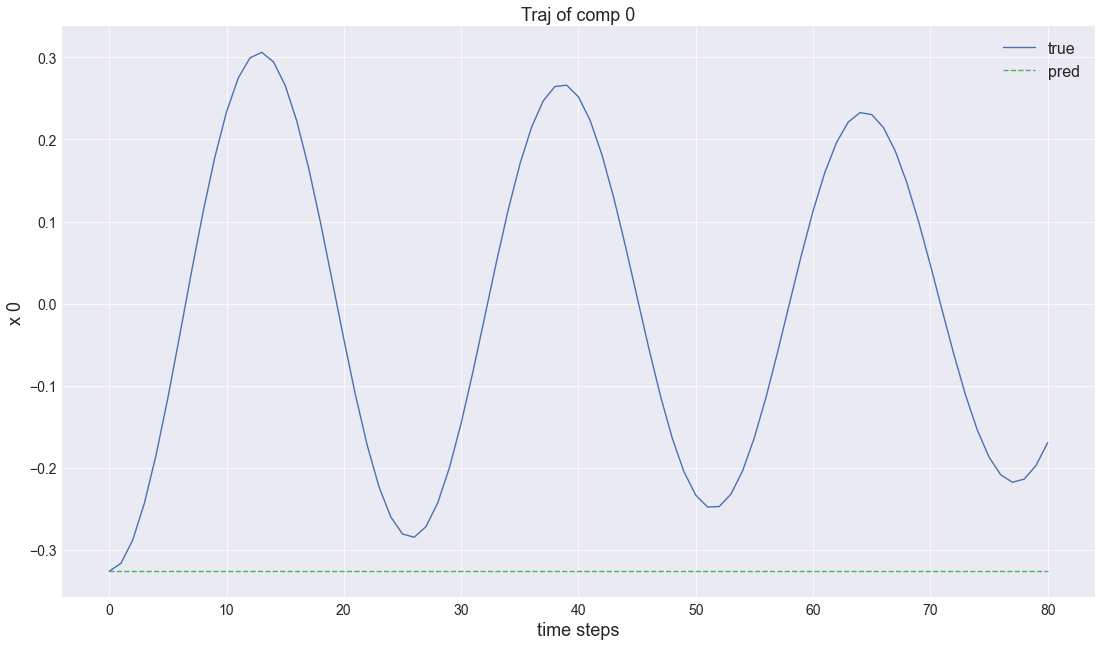

In [24]:
xtest = xdata[:,95, :, :]
test_traj(xtest, ode1)

In [49]:
errs = np.load('data/err_stable.npy')

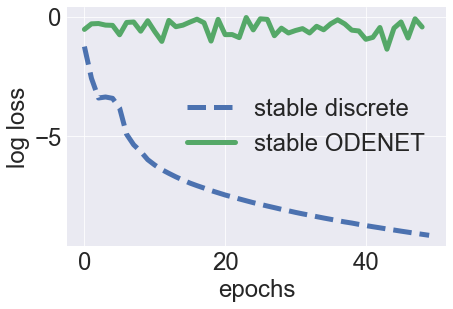

In [63]:
plt.plot(np.log(errs[:50]), '--', linewidth=5, label='stable discrete')
plt.plot(np.log(batch_err), linewidth=5, label='stable ODENET')
plt.ylabel('log loss', fontsize = 24)
plt.xlabel('epochs', fontsize = 24)
plt.tick_params('both', labelsize=24)
plt.legend(prop={'size': 24})
plt.tight_layout()
plt.savefig('../Notes/loss_odenet.png')

In [52]:
np.mean(batch_rt)*9

4.468458638191223

In [62]:
batch_err.pop(9)

inf

# multi D

In [ ]:
xdata = load_matlab('../matlab/eady_fb_mimo.mat')

In [12]:
xdim = xdata.shape[-1]
zdim = xdim*2
func = ode_mdl(zdim, xdim)

In [13]:
train_step, val_step = train_fcns(func, 1e-3)

In [14]:
rt = train_loop(10, train_step, val_step)

Batch 0000:
Training acc over epoch: 0.101649
Batch runtime: 0.70s
Batch 0001:
Training acc over epoch: 0.094533
Batch runtime: 0.65s
Batch 0002:
Training acc over epoch: 0.084782
Batch runtime: 0.86s


KeyboardInterrupt: 